In [1]:
# Step 1: Setup Environment
import os
import numpy as np
from PIL import Image  # Import PIL for handling GIFs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 3: Download and Unzip Dataset (Uncomment if not done previously)
!pip install -q kaggle
# Upload your kaggle.json and run the below commands
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhaysharma38/indian-folk-art-gallery-high-resolution-images
!unzip indian-folk-art-gallery-high-resolution-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/282.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/283.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/284.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/285.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/286.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/287.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/288.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/289.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/29.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/290.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/291

In [5]:

# Step 4: Load and Preprocess Images
image_dir = '/content/folk-art-dataset-main/'  # Change if necessary
labels = os.listdir(image_dir)
IMG_SIZE = 128  # Image dimensions
images = []
image_labels = []

def load_images(image_dir, labels):
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                file_extension = img_file.split('.')[-1].lower()  # Get file extension
                if file_extension not in ['jpg', 'jpeg', 'png', 'gif']:  # List of supported formats
                    print(f"Unsupported format for image: {img_path}")
                    continue

                try:
                    # Use PIL for opening GIFs and other formats
                    image = Image.open(img_path)

                    # Convert image to RGB, handling palette images
                    image = image.convert('RGB')
                    image = image.resize((IMG_SIZE, IMG_SIZE))  # Resize to IMG_SIZE
                    image = np.array(image)  # Convert to numpy array

                    # Ensure the image shape is as expected
                    if image.shape == (IMG_SIZE, IMG_SIZE, 3):
                        images.append(image)
                        image_labels.append(label)
                    else:
                        print(f"Image shape mismatch for {img_path}: {image.shape}")
                except Exception as e:
                    print(f"Error loading image: {img_path} - {e}")

load_images(image_dir, labels)

# Convert images to numpy array
images = np.array(images, dtype='float32')
# Normalize pixel values to [0, 1]
images /= 255.0

# Map labels to numerical values
label_to_num = {label: idx for idx, label in enumerate(np.unique(image_labels))}
numerical_labels = np.array([label_to_num[label] for label in image_labels])
y_categorical = to_categorical(numerical_labels, num_classes=len(label_to_num))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, y_categorical, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input size and number of labels
IMG_SIZE = 128  # or your dataset's input image size
num_classes = len(label_to_num)  # Number of classes in your dataset

# Load the pre-trained MobileNetV2 model (without the top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce dimensionality
x = Dense(128, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(num_classes, activation='softmax')(x)  # Output layer for classification

# Create the complete model
mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming X_train, y_train, X_val, y_val are defined)
mobilenet_history = mobilenet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Save the model if needed
mobilenet_model.save('/content/drive/MyDrive/mobilenet_folk_art_model50.h5')

# Print the model summary
mobilenet_model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
808/808 [==============================] - 72s 86ms/step - loss: 2.2879 - accuracy: 0.3647 - val_loss: 1.5710 - val_accuracy: 0.5634
Epoch 2/50
808/808 [==============================] - 68s 84ms/step - loss: 1.7009 - accuracy: 0.5121 - val_loss: 1.3711 - val_accuracy: 0.6226
Epoch 3/50
808/808 [==============================] - 66s 82ms/step - loss: 1.5133 - accuracy: 0.5615 - val_loss: 1.2889 - val_accuracy: 0.6434
Epoch 4/50
808/808 [==============================] - 66s 82ms/step - loss: 1.3787 - accuracy: 0.5917 - val_loss: 1.1959 - val_accuracy: 0.6636
Epoch 5/50
808/808 [==============================] - 68s 84ms/step - loss: 1.2945 - accuracy: 0.6169 - val_loss: 1.1418 - val_accuracy: 0.6810
Epoch 6/50
808/808 [==============================] - 68s 84ms/step - loss: 1.2127 - accuracy: 0.6360 - val_loss: 1.1060 - val_accuracy: 0.6964
Epoch 7/50
808/808 [==============================] - 68s 84ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

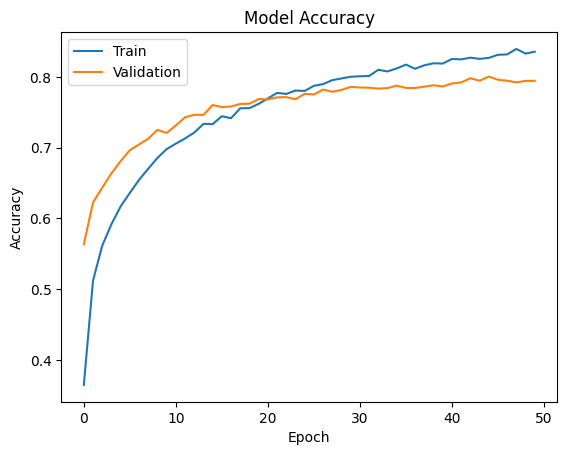

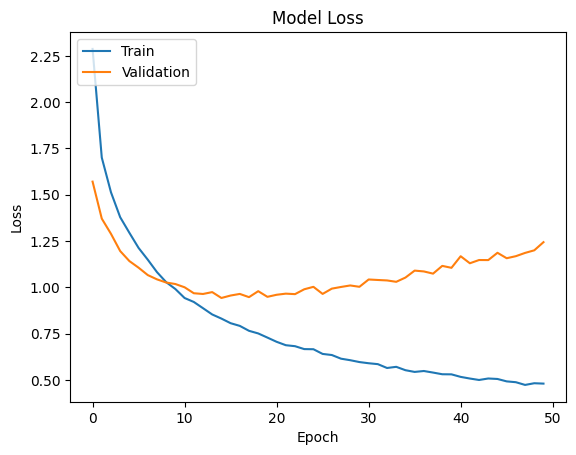

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Assuming you have already trained the model
# Plot training & validation accuracy and loss
def plot_accuracy_and_loss(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the plot function to visualize training progress
plot_accuracy_and_loss(mobilenet_history)
